In [1]:
# Import Packages
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Load Case-Shiller US National Home Price Index
# Seasonally Adjusted
df_sa = pd.read_csv("CSUSHPISA.csv", parse_dates=["DATE"], index_col="DATE")
df_sa.rename(columns = {'CSUSHPISA':'home_price'}, inplace = True)

# Check for Missing Values
if (df_sa.isnull().values.any()):
    print('The df_sa data frame has missing observations')
else:
    print('The df_sa data frame has NO missing observations')

The df_sa data frame has NO missing observations


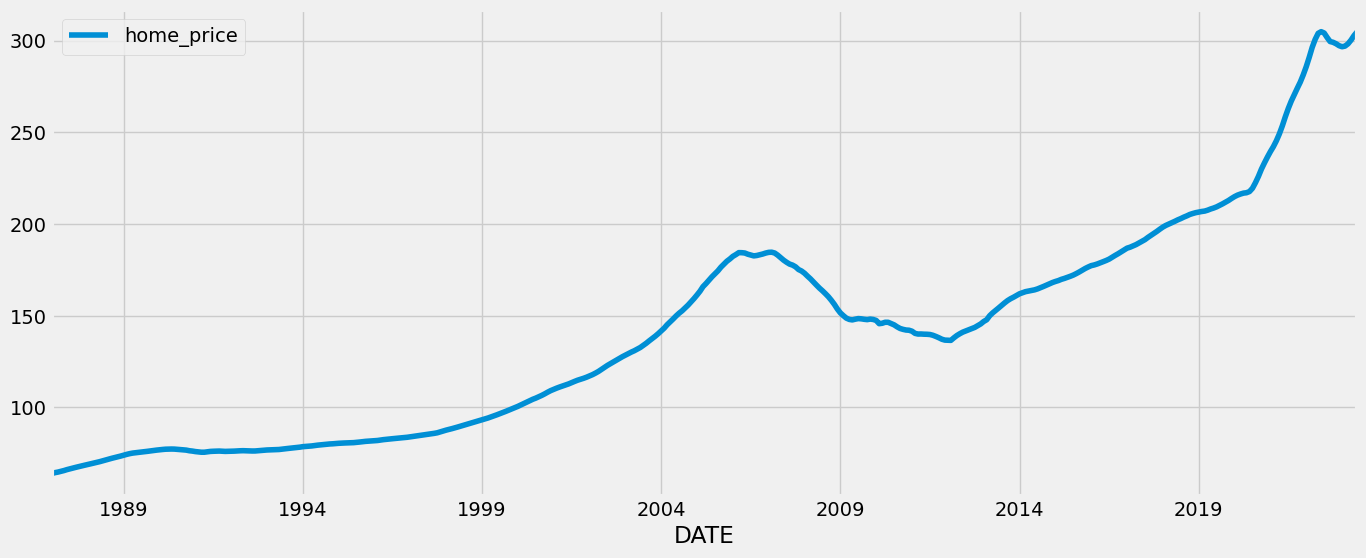

In [3]:
df_sa.plot(figsize=(15, 6))
plt.show()

In [4]:
# Create custom function to perform augmented Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller

def run_adftest(ts):
    
    augmented_df_result = adfuller(ts)
    adf_stat = augmented_df_result[0]
    adf_pvalue = augmented_df_result[1]
    
    # Report Results
    print('The Augmented Dickey Fuller Test Statistic is: %f' % adf_stat)
    print('with a p-value of: %f' % adf_pvalue)
    if (adf_pvalue <= 0.05):
        print('therefore, we reject the null hypothesis of a unit root')
    else:
        print('therefore, we CANNOT reject the null hypothesis of a unit root')
    
    return None

adf_result = run_adftest(df_sa.home_price)


The Augmented Dickey Fuller Test Statistic is: 1.028806
with a p-value of: 0.994561
therefore, we CANNOT reject the null hypothesis of a unit root


In [5]:
# Now, we will first difference the SA Home Price Series
d_home_price = df_sa.home_price.diff().dropna()

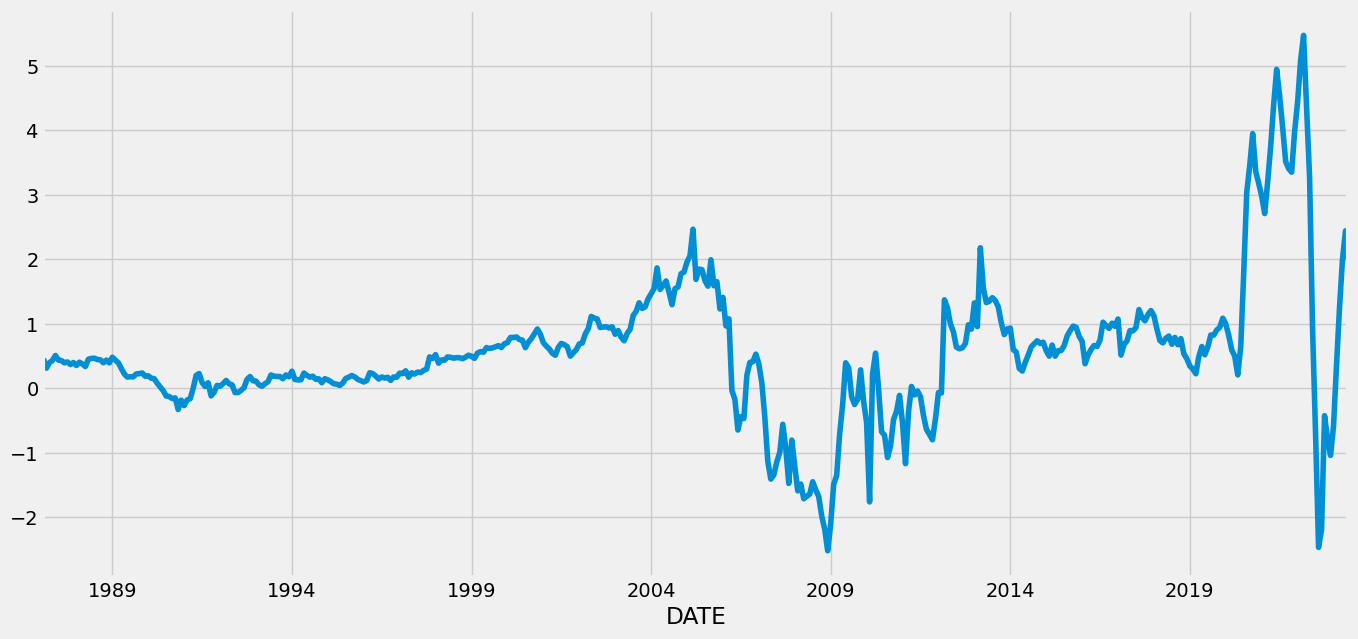

In [6]:
# Plot the first difference of the home price index
d_home_price.plot(figsize=(15, 7))
plt.savefig('d_home_price.png')
plt.show()

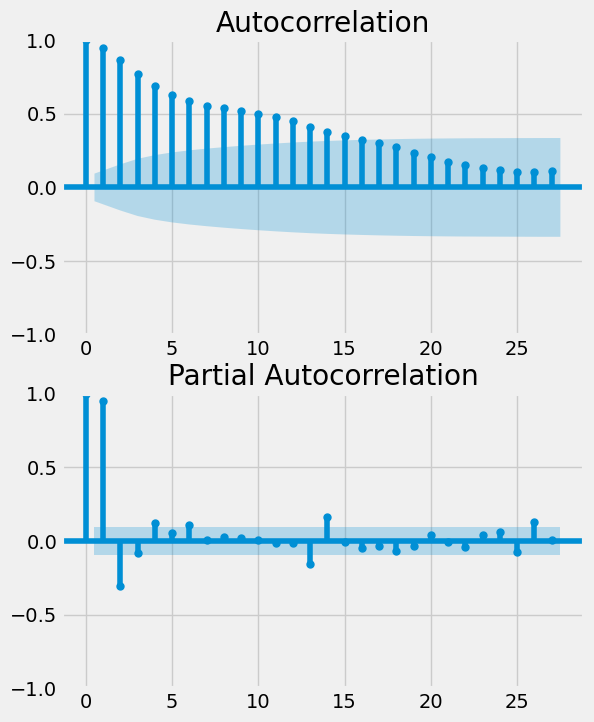

In [7]:
# Plot the First difference and the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1, ax2 = axes.flatten()
plot_acf(d_home_price, ax=ax1)
plot_pacf(d_home_price, ax=ax2)
plt.savefig('acf_and_pacf_d1.png')
plt.show()

In [8]:
# Run the ADF Test of the 1st Differenced Data
adf_result = run_adftest(d_home_price)

The Augmented Dickey Fuller Test Statistic is: -2.703482
with a p-value of: 0.073438
therefore, we CANNOT reject the null hypothesis of a unit root


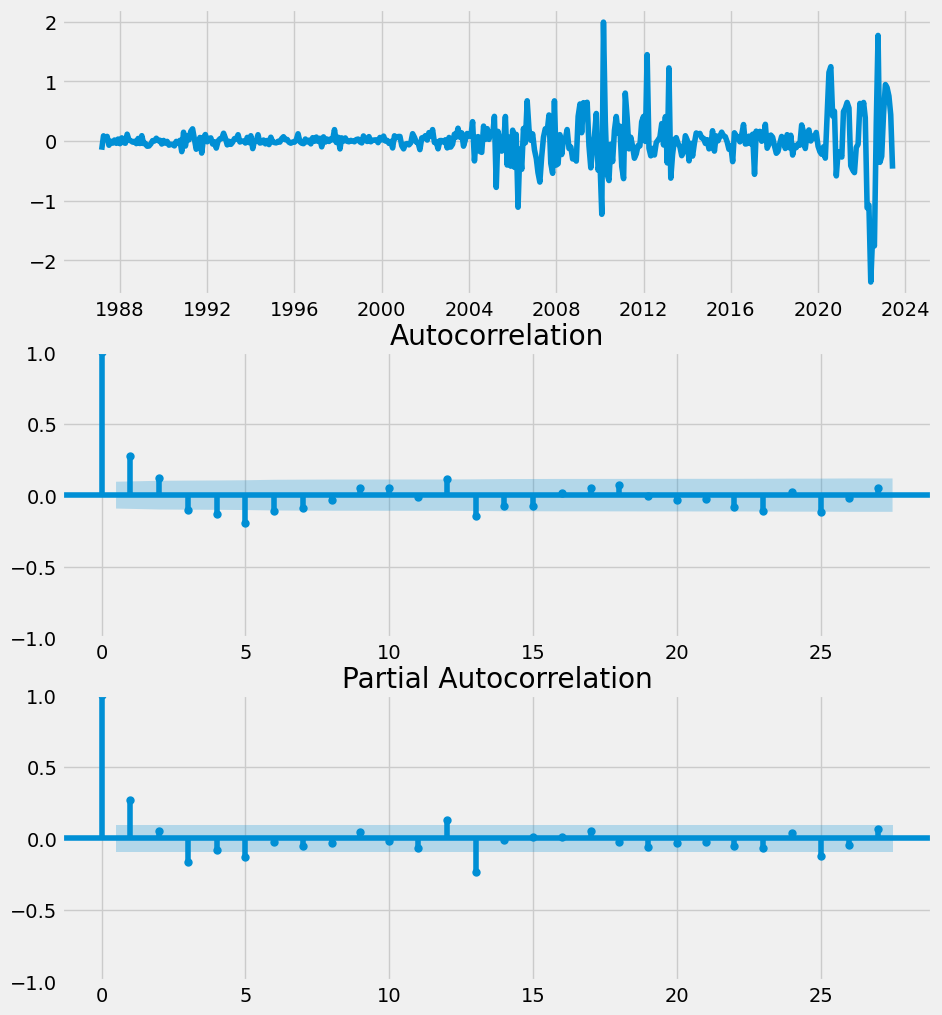

In [9]:
# Now, we will second difference the SA Home Price Series
d2_home_price = d_home_price.diff().dropna()

# Plot the Second difference and the ACF and PACF
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
ax1, ax2, ax3 = axes.flatten()

ax1.plot(d2_home_price)
plot_acf(d2_home_price, ax=ax2)
plot_pacf(d2_home_price, ax=ax3)
plt.savefig('acf_and_pacf_d2.png')
plt.show()

In [10]:
# Run the ADF Test of the 2nd Differenced Data
adf_result = run_adftest(d2_home_price)

The Augmented Dickey Fuller Test Statistic is: -7.251626
with a p-value of: 0.000000
therefore, we reject the null hypothesis of a unit root


In [11]:
# Train/Test Split (hold back the last 5 years = 60 monthly obs.)

home_price = df_sa.home_price

hp_train = home_price[:(len(home_price)-60)]
hp_test = home_price[(len(home_price)-60):]

<Axes: xlabel='DATE'>

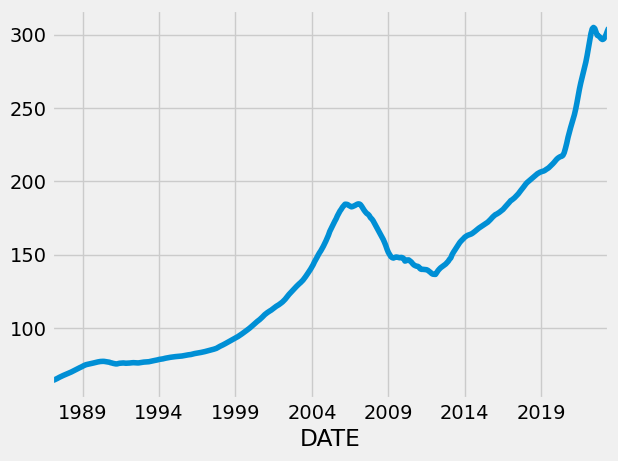

In [12]:
home_price.plot()

In [13]:
# Evaluate Forecast Accuracy: Mean Absolute Percentage Error

def forecast_mape(actual,forecast):
    abs_norm_resid = np.abs((forecast - actual)/actual)
    mape = np.mean(abs_norm_resid)
    return 100*mape

def forecast_rmse(actual,forecast):
    mean_sq_resid = np.mean((forecast - actual)**2)
    return mean_sq_resid**(0.5)

In [18]:
# Grid Search for best performing ARIMA model
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Define the p, d and q parameters to take any value between 0 and 1
p = range(1, 4) # AR term goes back 1 and 3 quarters
d = range(1, 3) # Order of integration is either 1 or 2
q = range(0, 4) # MA term goes back 0 to 3 quarters

# Generate all different combinations of p, q and q triplets (take Cartesian Product = p x d x q)
pdq = list(itertools.product(p, d, q))

#low_aic = float('inf')
#aic_model_mape = 0
#best_param = None

model_parameters_and_performance = []

for param in pdq:
    
    try:
        model = ARIMA(hp_train, order=param)
        results = model.fit()
        results_aic = results.aic
        results_bic = results.bic
        
        # Forecast 60 months ahead
        forecast = results.forecast(60)
        precision = forecast_mape(hp_test,forecast)
        fcast_rmse = forecast_rmse(hp_test,forecast)
        
        next_row = (param[0], param[1], param[2], results_aic, results_bic, precision, fcast_rmse)
        
        model_parameters_and_performance.append(next_row)

#        if (results_aic < low_aic):
#            low_aic = results_aic
#            aic_model_mape = precision
#            best_param = param
#            print('ARIMA{} - AIC: {}* - mean abs percentage error: {}%'.format(param, results_aic, precision))
#        else:
#            print('ARIMA{} - AIC: {} - mean abs percentage error: {}%'.format(param, results_aic, precision))
               
    except:
        continue

# Print Best Parameters
# print('>>> The best ARIMA parameters are {} - AIC:{} - mean abs percentage error: {}%'.format(best_param, low_aic, aic_model_mape))


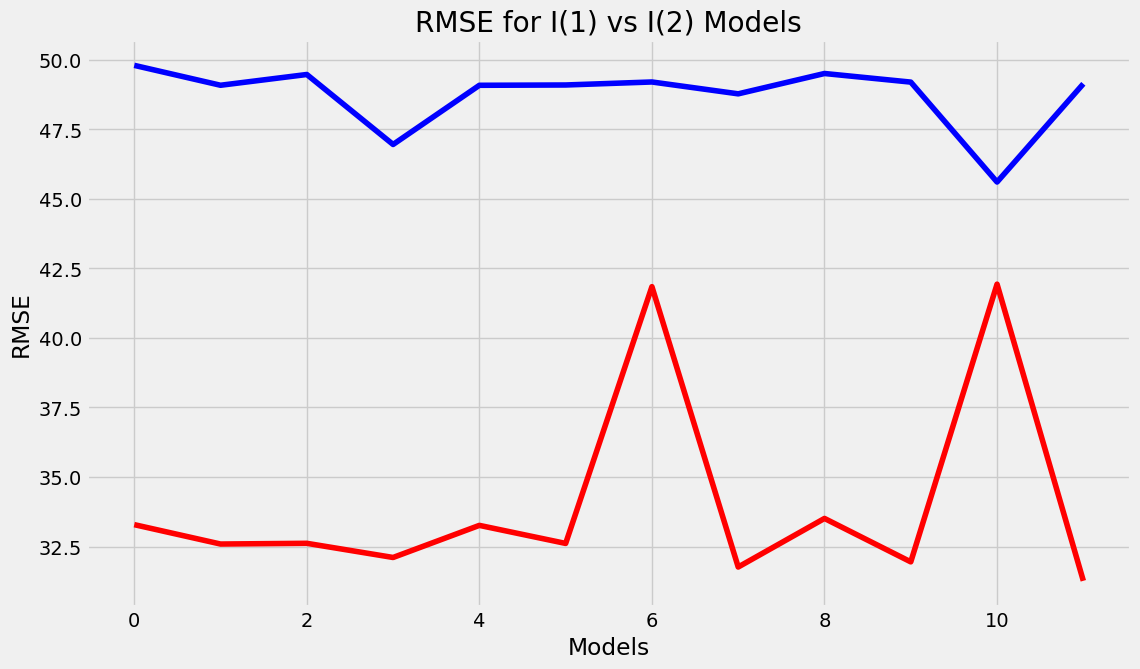

In [26]:
# Comparing RMSE Forecasting Performance in the I(1) vs I(2) ARIMA Models

model_df = pd.DataFrame(model_parameters_and_performance, columns=['p','d','q','aic','bic','forecast_mape','forecast_rmse'])

plt.figure(figsize=(12,7), dpi=100)
plt.plot(model_df.loc[(model_df.d == 1)]['forecast_rmse'].reset_index(drop=True), color='blue')
plt.plot(model_df.loc[(model_df.d == 2)]['forecast_rmse'].reset_index(drop=True), color='red')
plt.title('RMSE for I(1) vs I(2) Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.savefig('forecast_rmse.png')
plt.show()

In [29]:
# Filter dataframe where the parameter d = 2
model_df.loc[(model_df.d == 2)]

,p,d,q,aic,bic,forecast_mape,forecast_rmse
4,1,2,0,45.221397,53.080575,8.310721,33.288430
5,1,2,1,35.192794,46.981561,8.178871,32.591294
6,1,2,2,37.092669,52.811025,8.183839,32.617123
7,1,2,3,42.090489,61.738435,8.082213,32.108054
12,2,2,0,47.195396,58.984163,8.305636,33.261844
13,2,2,1,37.102255,52.820611,8.183046,32.612991
14,2,2,2,31.218707,50.866653,10.271617,41.842795
15,2,2,3,34.237330,57.814865,8.014971,31.764967
20,3,2,0,42.782476,58.500832,8.354603,33.511388
21,3,2,1,41.289056,60.937002,8.054755,31.950062


In [30]:
# ARIMA(1,2,1) Forecast from July 2018 to June 2023 
model1 = ARIMA(hp_train, order=(1,2,1))
results1 = model1.fit()
forecast1 = results1.forecast(60)

# ARIMA(3,2,3) Forecast From July 2018 to June 2023 
model2 = ARIMA(hp_train, order=(3,2,3))
results2 = model2.fit()
forecast2 = results2.forecast(60)
       
# Confidence Intervals Model 1
forecast_and_ci1 = results1.get_forecast(60, alpha=0.05)
confidence_intervals1 = forecast_and_ci1.conf_int()

# Confidence Intervals Model 2
forecast_and_ci2 = results2.get_forecast(60, alpha=0.05)
confidence_intervals2 = forecast_and_ci2.conf_int()


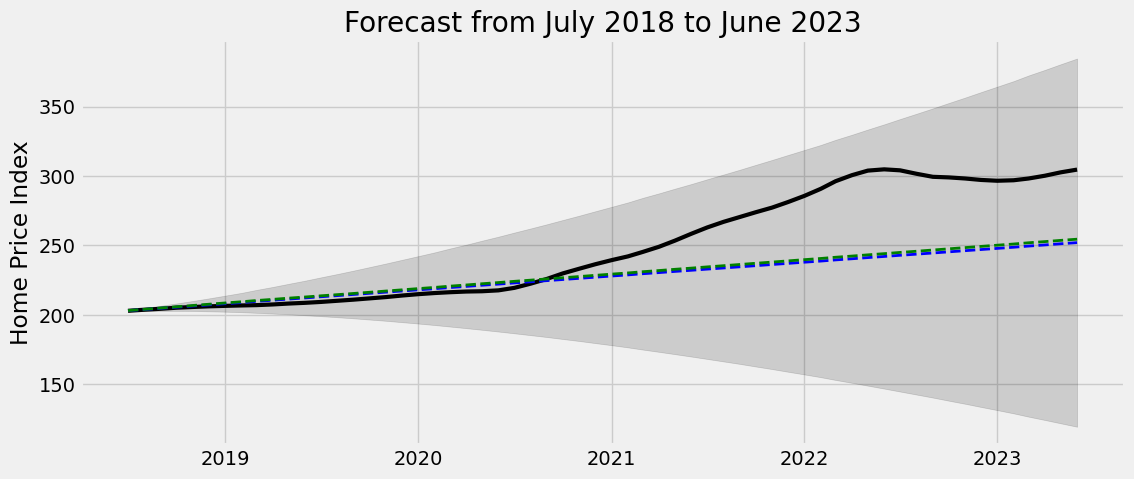

In [40]:
# Plot Forecast over Holdback (Test) Period
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(hp_train, color='black')
plt.plot(hp_test, color='black', linewidth=3)
plt.plot(forecast1, color='blue', linestyle='dashed', linewidth=2)
plt.plot(forecast2, color='green', linestyle='dashed', linewidth=2)
plt.fill_between(confidence_intervals1['lower home_price'].index, confidence_intervals1['lower home_price'], confidence_intervals1['upper home_price'], color='k', alpha=0.15)
plt.ylabel('Home Price Index')
plt.title('Forecast from July 2018 to June 2023')
plt.savefig('forecast_2018to2023.png')
plt.show()

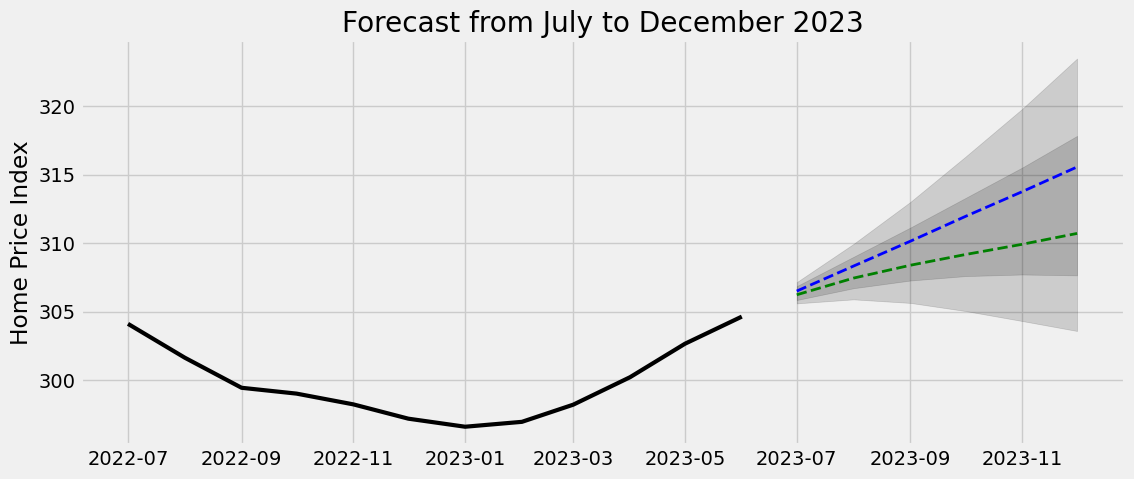

In [49]:
# Forecast Home Prices Over Q3 and Q4 2023

# ARIMA(1,2,1)
model1 = ARIMA(home_price, order=(1,2,1)) # Use entire sample to estimate/train model
results1 = model1.fit()
forecast_and_ci1 = results1.get_forecast(6, alpha=0.05)
confidence_intervals1 = forecast_and_ci1.conf_int()
forecast1 = results1.forecast(6)

# ARIMA(3,2,3)
model2 = ARIMA(home_price, order=(3,2,3)) # Use entire sample to estimate/train model
results2 = model2.fit()
forecast_and_ci2 = results2.get_forecast(6, alpha=0.05)
confidence_intervals2 = forecast_and_ci2.conf_int()
forecast2 = results2.forecast(6)

# Plot Forecasts
plt.figure(figsize=(12,5), dpi=100)
plt.plot(home_price[(len(home_price)-12):], color='black', linewidth=3)
plt.plot(forecast1, color='blue', linestyle='dashed', linewidth=2)
plt.plot(forecast2, color='green', linestyle='dashed', linewidth=2)
plt.fill_between(confidence_intervals1['lower home_price'].index, confidence_intervals1['lower home_price'], confidence_intervals1['upper home_price'], color='k', alpha=0.15)
plt.fill_between(confidence_intervals2['lower home_price'].index, confidence_intervals2['lower home_price'], confidence_intervals2['upper home_price'], color='k', alpha=0.15)
plt.ylabel('Home Price Index')
plt.title('Forecast from July to December 2023')
plt.savefig('forecast_q3q42023.png')
plt.show()
